### Setting
1. Task: We are given $z$ 3D TIFF slices generated by a Python script, with each TIFF slice z-dimension being an array of $x$ by $y$ with values ranging from 0 to 255. We want to estimate the number of cell bodies in a given area and a given number of the $z$ slices.  
2. Loss function: We will evaluate loss through a percent-error analysis [ie: observed less expected over expected]. What this entails is after we receive the "true" number of cell counts from Ailey for a given region, we'll compare the results from our classifier to see whether or not we are near the expected results.
3. Statistical goal: Learn a classifier that distinguishes cell bodies [minimizes O-E/E].
4. Desiderata: We desire a classifier that:  
    i. Estimates the number of cells in a given image to a reasonable degree of accuracy  
    ii. Empirically performs well on the real data  
    iii. Is fast, computationally-speaking  
    iv. Is easy to use  

### Approach

First, we'll analyze http://bcfind.dinfo.unifi.it/.  This is an open source Python light sheet microscopy cell classifier for brain cells.  I liked this implementation because:  
1)  The source code is in Python, so incorporation or partial usage in our pipeline would be simple.  
2)  From a cursory analysis of the technical and runtime instructions, I think I'd be interested in running through this to see what results we get.  

Thus, for this week I'll analyze the source code to discern how the methods entailed therein function. Most notably, I'll do a mathematical analysis of the main algorithms, which include:  
1)  Process for generating substacks and generating substacks with overlapping pieces  
2)  The mean shift algorithm (and its unique implementation)  
3)  The "supervised semantic deconvolution" (what parameters are they inputting to get this to work?)
4)  "Manifold learning" to filter out false positives.

### Pseudocode and Analysis

Analysis on: https://academic.oup.com/bioinformatics/article/30/17/i587/201138/Large-scale-automated-identification-of-mouse  
[Large-scale automated identification of mouse brain cells in confocal light sheet microscopy images]  

From the analysis of the written paper, the methods purport to function with three main algorithmic steps:   
1) Apply a version of the mean shift algorithm to determine cell centers.  
2) Apply a "supervised semantic deconvolution" filter to "brighten" darker somas to ensure all somas are included.  
3) "Manifold learning" to filter out false positives.   

####  Part 0:  Substack Generation

The entire data set is split into substacks.  They do this for three main reasons:  
1)  Substacks allow for finding a local threshold technique, as opposed to having a computationally expensive task dedicated to calculating the "background" for different areas.  
2)  Dividing an image into substacks allows a multi-threaded processor to individually process substacks, expediting the overall segmentation task.  
3)  It is easier to work on individual substacks for the manual annotation stages (i.e. smaller file size) to establish estimates for the ground truth.

Each substack had dimensions (W x H x D), where W is the width, H is the height, and D is the depth.  However, some cells may be cut off along the borders of the substack.  To prevent this phenomena from adding unnecessary noise to the cell detection process, they defined a margin "M".  M is the maximum size of a cell (in voxels).  Only centroids/cells found within (W - M) x (H - M) x (D - M) were thus considered in final processing, as centroids/cells in these areas are guaranteed to fall within the full dimensions of (W x H x D).  I was personally curious as to the error rate created by constantly omitting a margin "M" - perhaps I'm missing something.  I've included an image of the diagram from the paper below explaining the methodology.  

![substackcells](cellfindersubstack.png)

**Figure 1:** Overlapping of substacks (depicted in 2D for simplicity). Processing is carried out in the region of size W × H but detected cells are only accepted if their centers fall within the region of size  (W−M)×(H−M)(W−M)×(H−M)  (delimited by dashed lines). Sample accepted and rejected cells after processing the central substack are shown as light and dark circles, respectively.

####  Part 1:  Mean Shift Algorithm Implementation  
(Source Code:  http://bcfind.dinfo.unifi.it/_modules/bcfind/mscd.html)  

We're now working with each individual substack.  The algorithm attempts to output "cluster centroids" that (ideally) would correspond to the soma centers.  Essentially, mean shifting is an approach where the entire feature space (in this case the XYZ coordinates and the intensity value) is considered as an empirical probability distribution function.  If each input is a set of points, then the mean shift considers them sampled from the underlying pdf.  From there, dense regions (or clusters) which are present in the feature space correspond to the mode (local maxima) of that pdf.

![meanshift](meanshiftalgorithmpseudo.png)

####  Part 2:  Supervised Semantic Deconvolution  
(Source Code:  http://bcfind.dinfo.unifi.it/_modules/bcfind/semadec/deconvolver.html#Predictor)  

The above code works well for individual substacks and finding cell somas, but fails when the image contrast isn't good enough/cell bodies are darker in other substacks.  To fix this problem, the paper went and trained two fully connected hidden layer neural networks with the goal being to predict, for each voxel, the conditional probability that it falls in a white (soma) area of the original (training) image.

The implementation of the network is all done in Python.  I quote, "the goal of semantic deconvolution is not to undo the blurring or degradation effects associated with the image acquisition process (as in classic deconvolution) but rather to enhance and standardize the visibility of specific entities of interest in the image (somata in our case). We trained a neural network to map the original image into an ‘ideal’ image, which is entirely black except for small white spheres positioned at the locations of the true cell somata."  While neural networks are difficult to work with, our histogram equalization techniques should (theoretically, at least) do something similar.

![supervisedsemanticdeconvolution](semanticdeconvolutionimg.png)

####  Part 3:  Manifold Modelling  
(Source Code:  http://bcfind.dinfo.unifi.it/_modules/bcfind/mscd.html)  

The paper goes on to discuss how, for certain areas of the brain (i.e. the cerebellum), cells are distributed in a "manifold" pattern.  Since we are not working with just the cerebellum, I've excluded analysis on this part.

### Example of Mean Shift Algorithm on Points in 3D

In [1]:
## Following https://github.com/log0/build-your-own-meanshift/blob/master/Meanshift%20In%202D.ipynb
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from sklearn.datasets import *
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12

(100, 3)


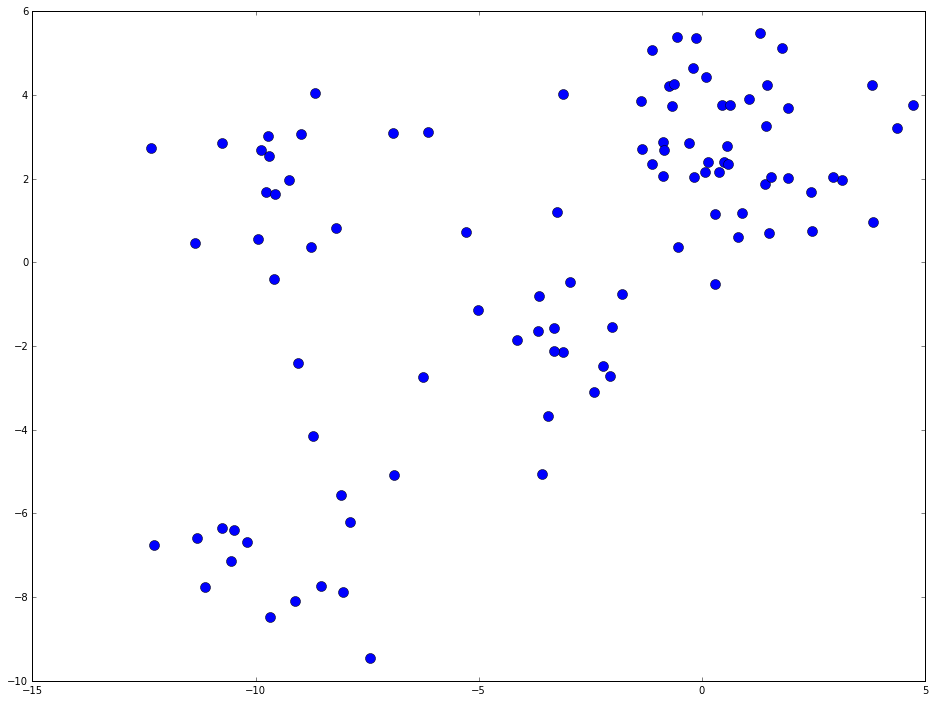

In [64]:
## Generate points in 3D space, with std. dev 1.5 ("bad" example)
from mpl_toolkits.mplot3d import Axes3D
original_X, X_shapes = make_blobs(100, 3, centers=6, cluster_std=1.5)
print(original_X.shape)

## Show 2D cross section.
plt.plot(original_X[:,0], original_X[:,1], 'bo', markersize = 10)

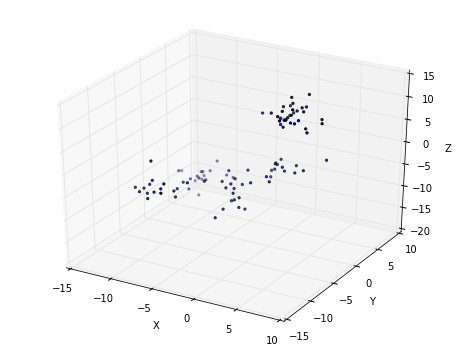

In [65]:
## Plot points in 3D space.

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

yg = ax.scatter(original_X[:,0], original_X[:,1], original_X[:,2], marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [66]:
## Use Euclidean Distance for evaluating nearest neighbor.  Use Gaussian Kernel for the kernel density estimates.

def euclid_distance(x, xi):
    return np.sqrt(np.sum((x - xi)**2))

def neighbourhood_points(X, x_centroid, distance = 5):
    eligible_X = []
    for x in X:
        distance_between = euclid_distance(x, x_centroid)
        # print('Evaluating: [%s vs %s] yield dist=%.2f' % (x, x_centroid, distance_between))
        if distance_between <= distance:
            eligible_X.append(x)
    return eligible_X

def gaussian_kernel(distance, bandwidth):
    val = (1/(bandwidth*math.sqrt(2*math.pi))) * np.exp(-0.5*((distance / bandwidth))**2)
    return val

In [67]:
from sklearn import cluster
sklearn.cluster.estimate_bandwidth(original_X, quantile=0.3, n_samples=None, random_state=0)

6.8727308436469983

In [68]:
## Define window and kernel bandwidth.  The kernel bandwidth is estimated using
## sklearn.cluster.estimate_bandwidth

look_distance = 5  # How far to look for neighbours.
kernel_bandwidth = 7  # Kernel parameter.

In [69]:
X = np.copy(original_X)
# print('Initial X: ', X)

past_X = []
n_iterations = 5
for it in range(n_iterations):
    # print('Iteration [%d]' % (it))    

    for i, x in enumerate(X):
        ### Step 1. For each datapoint x ∈ X, find the neighbouring points N(x) of x.
        neighbours = neighbourhood_points(X, x, look_distance)
        # print('[%s] has neighbours [%d]' % (x, len(neighbours)))
        
        ### Step 2. For each datapoint x ∈ X, calculate the mean shift m(x).
        numerator = 0
        denominator = 0
        for neighbour in neighbours:
            distance = euclid_distance(neighbour, x)
            weight = gaussian_kernel(distance, kernel_bandwidth)
            numerator += (weight * neighbour)
            denominator += weight
        
        new_x = numerator / denominator
        
        ### Step 3. For each datapoint x ∈ X, update x ← m(x).
        X[i] = new_x
    
    # print('New X: ', X)
    past_X.append(np.copy(X))

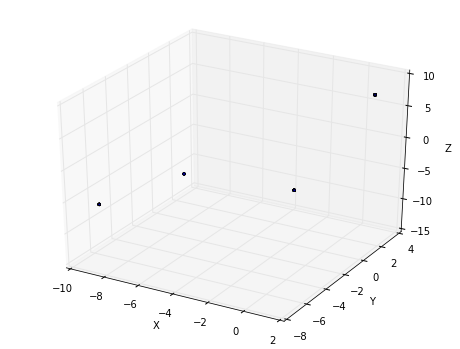

In [70]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

yg = ax.scatter(past_X[4][:,0], past_X[4][:,1], past_X[4][:,2], 'bo', marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

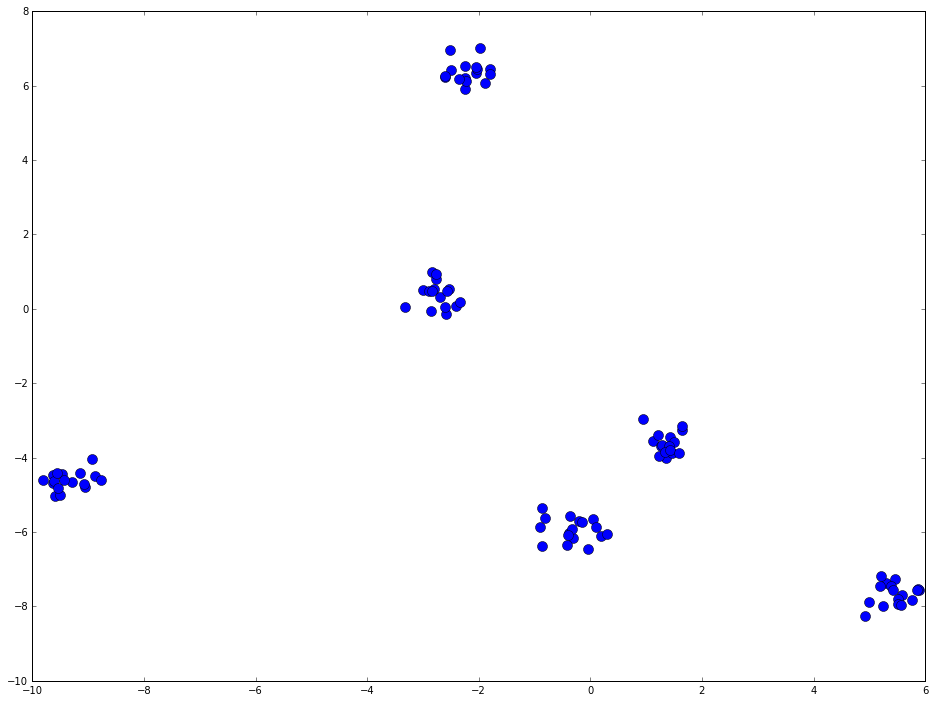

In [31]:
## Generate points in 3D, with low standard deviation ("good" example)
original_X_good, X_shapes = make_blobs(100, 3, centers=6, cluster_std=0.3)
plt.plot(original_X_good[:,0], original_X_good[:,1], 'bo', markersize = 10)

In [32]:
sklearn.cluster.estimate_bandwidth(original_X_good, quantile=0.3, n_samples=None, random_state=0)

7.7778701138441617

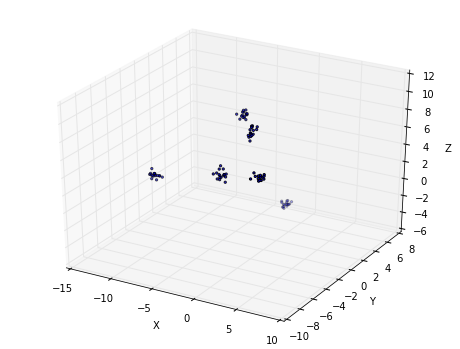

In [33]:
## Plot points in 3D space.

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

yg = ax.scatter(original_X_good[:,0], original_X_good[:,1], original_X_good[:,2], marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [52]:
## Define window and kernel bandwidth.  The kernel bandwidth is estimated using
## sklearn.cluster.estimate_bandwidth

look_distance = 5  # How far to look for neighbours.
kernel_bandwidth = 8  # Kernel parameter.

In [77]:
X = np.copy(original_X_good)
# print('Initial X: ', X)

past_X = []
n_iterations = 5
for it in range(n_iterations):
    # print('Iteration [%d]' % (it))    

    for i, x in enumerate(X):
        ### Step 1. For each datapoint x ∈ X, find the neighbouring points N(x) of x.
        neighbours = neighbourhood_points(X, x, look_distance)
        # print('[%s] has neighbours [%d]' % (x, len(neighbours)))
        
        ### Step 2. For each datapoint x ∈ X, calculate the mean shift m(x).
        numerator = 0
        denominator = 0
        for neighbour in neighbours:
            distance = euclid_distance(neighbour, x)
            weight = gaussian_kernel(distance, kernel_bandwidth)
            numerator += (weight * neighbour)
            denominator += weight
        
        new_x = numerator / denominator
        
        ### Step 3. For each datapoint x ∈ X, update x ← m(x).
        X[i] = new_x
    
    # print('New X: ', X)
    past_X.append(np.copy(X))

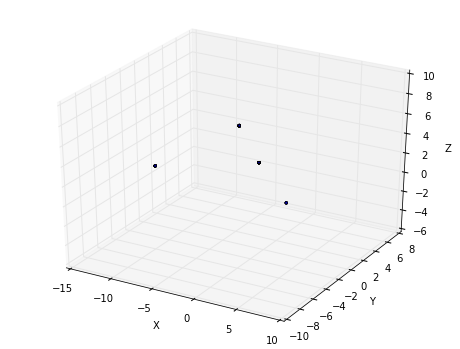

In [82]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

yg = ax.scatter(past_X[4][:,0], past_X[4][:,1], past_X[4][:,2], 'bo', marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## How well does it work?

We can see that in the end, the mean shift algorithm found 4 distinct cluster centroids (as opposed to the 6 that I initialized them with).  I also got 4 distinct clusters for the "good" simulation (eg: low standard deviation spread).  I found the best way to increase the cluster count was to decrease the window size (look_distance) parameter.

As for run time, the algorithm is known to be O(Kn^2), where K is the number of iteration attempts made before the algorithm converges.